In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import TFD, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook



In [2]:
size = 100
noise_std = 5e-2
alpha = .2
lr = 1e-2



In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TFD.generate_checker_data(5000)
net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True)


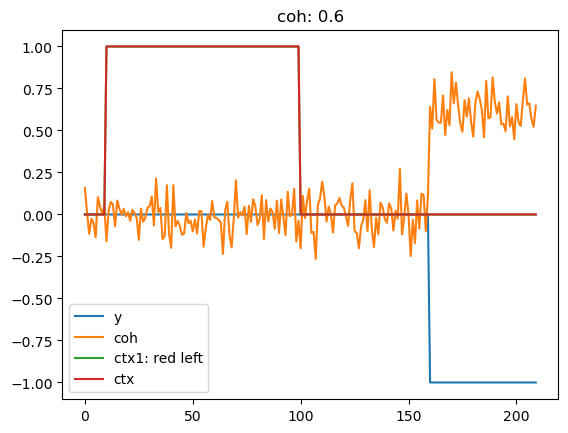

In [5]:
n = 1

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], label = 'ctx1: red left')
plt.plot(x_val[n,:,1], label = 'ctx')

plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




# train a full-rank RNN

In [6]:


net.non_linearity = torch.tanh

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr / sqrt(size), batch_size=50, keep_best=True, cuda=True, early_stop=0.03)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

Training...
initial loss: 1.000
epoch 0:  loss=0.597  (took 9.79 s) *
epoch 1:  loss=0.161  (took 9.43 s) *
epoch 2:  loss=0.112  (took 9.62 s) *
epoch 3:  loss=0.093  (took 9.36 s) *
epoch 4:  loss=0.087  (took 9.46 s) *
epoch 5:  loss=0.071  (took 9.44 s) *
epoch 6:  loss=0.064  (took 9.32 s) *
epoch 7:  loss=0.062  (took 9.69 s) *
epoch 8:  loss=0.056  (took 9.58 s) *
epoch 9:  loss=0.053  (took 9.56 s) *
epoch 10:  loss=0.053  (took 9.44 s) *
epoch 11:  loss=0.049  (took 9.69 s) *
epoch 12:  loss=0.046  (took 9.33 s) *
epoch 13:  loss=0.046  (took 9.42 s) *
epoch 14:  loss=0.042  (took 9.27 s) *
epoch 15:  loss=0.040  (took 9.26 s) *
epoch 16:  loss=0.038  (took 9.46 s) *
epoch 17:  loss=0.035  (took 9.52 s) *
epoch 18:  loss=0.036  (took 9.56 s)
epoch 19:  loss=0.033  (took 10.07 s) *
loss=0.035, acc=1.000


In [7]:


# save the model
torch.save(net.state_dict(), f'../models/TFD{size}.pt')

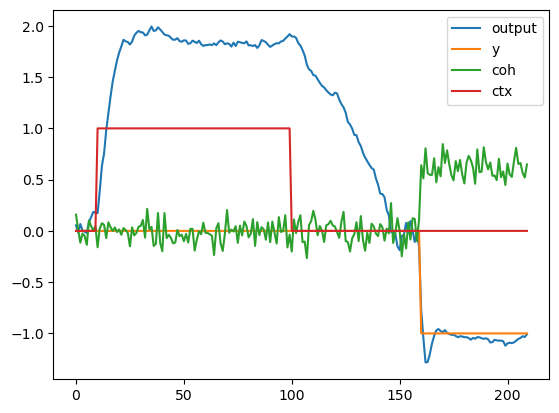

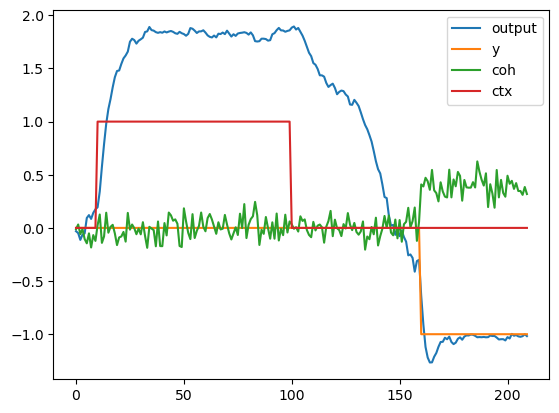

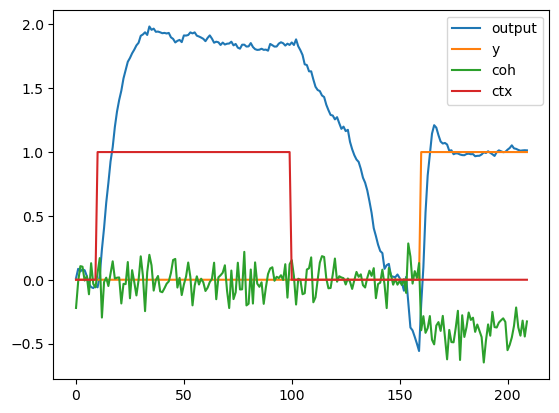

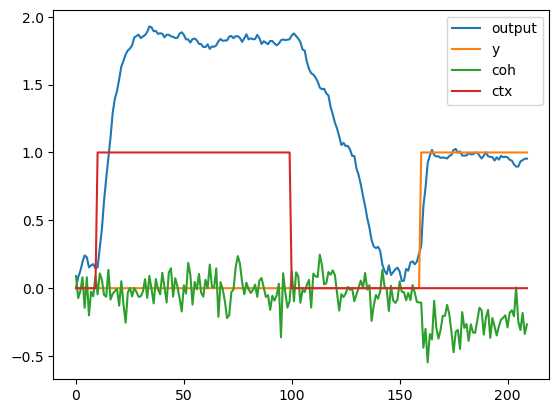

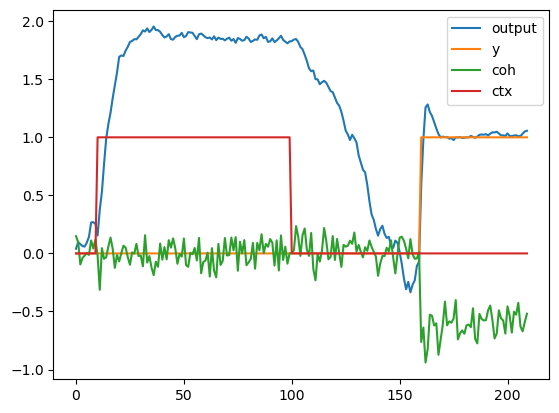

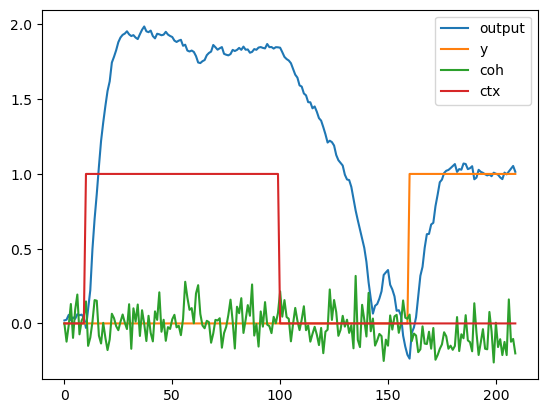

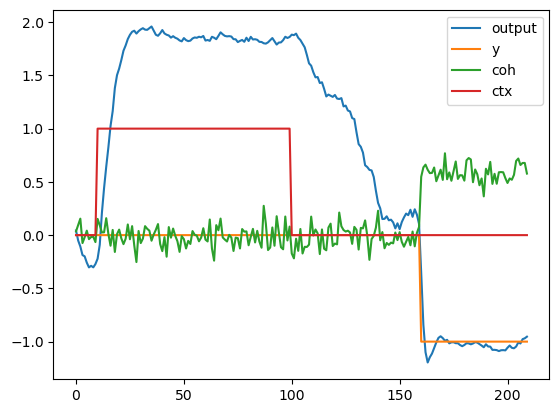

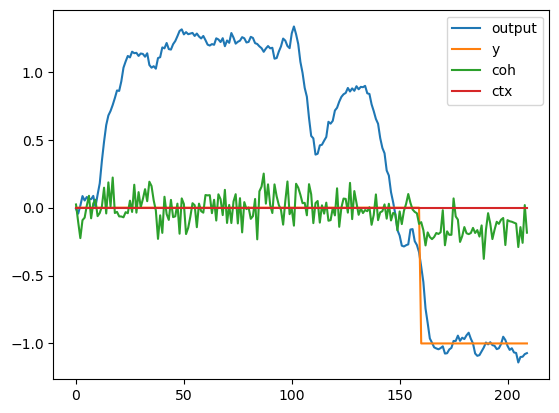

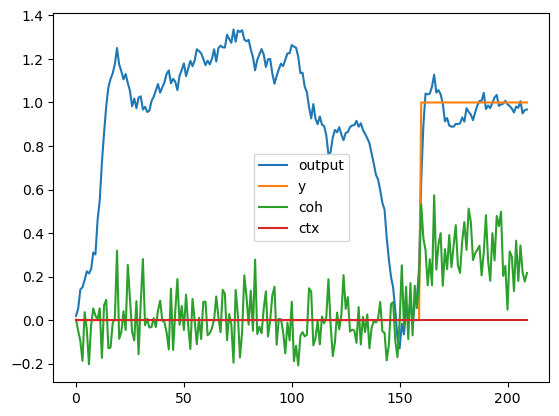

In [8]:
for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx')

    plt.legend()
    plt.show()

# plot psth

In [9]:
traj1 = traj.detach().numpy()

traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

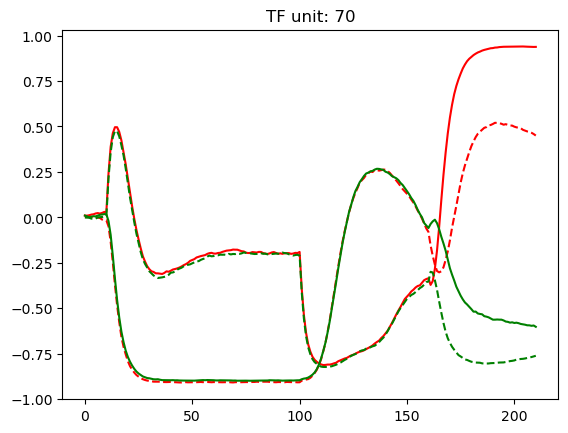

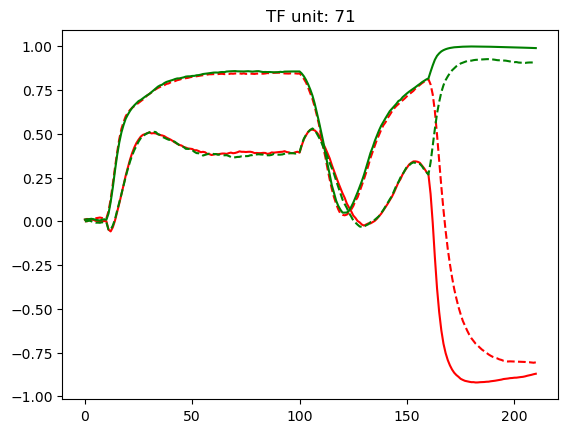

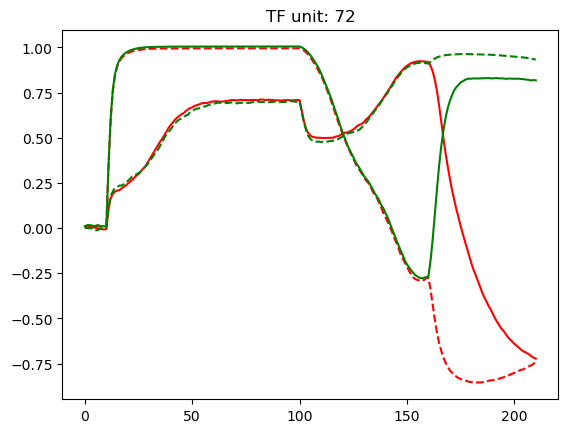

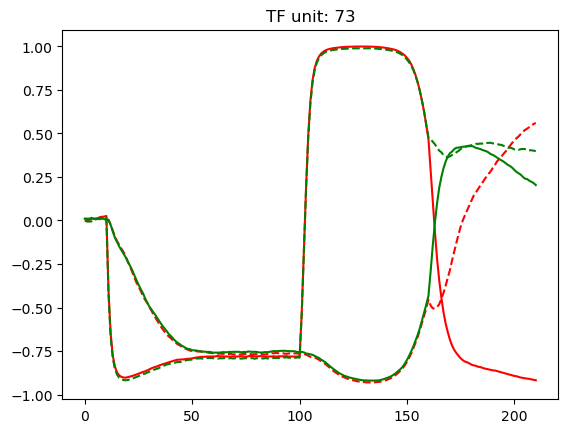

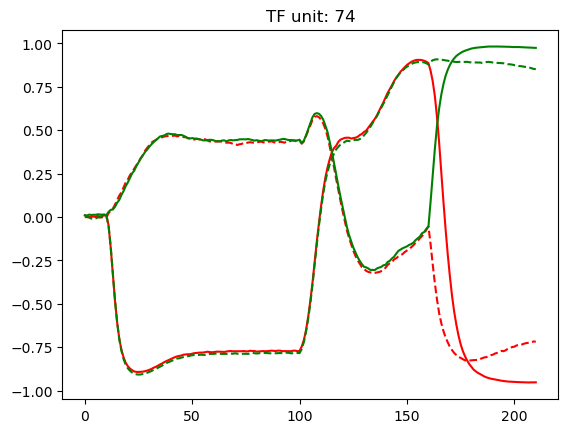

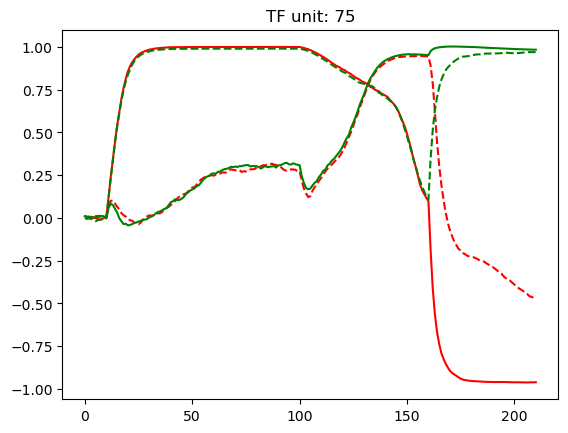

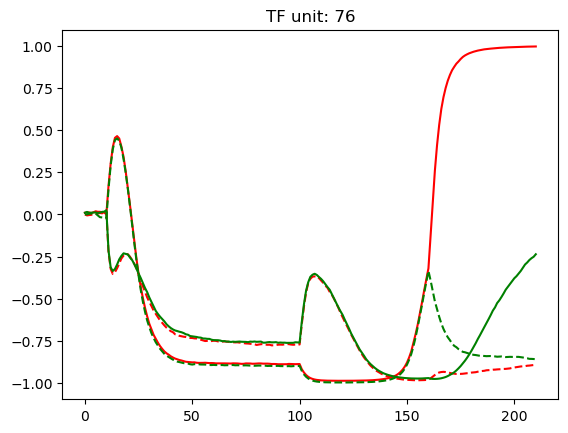

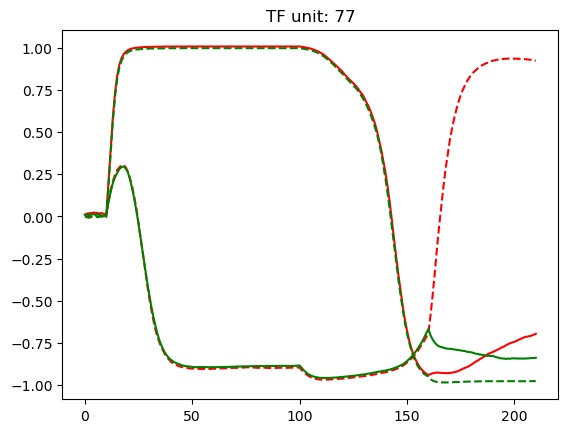

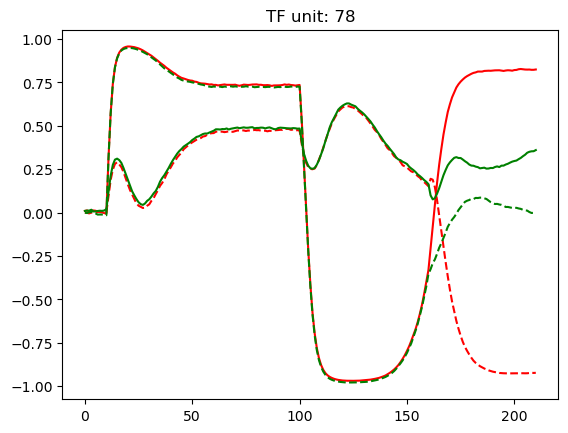

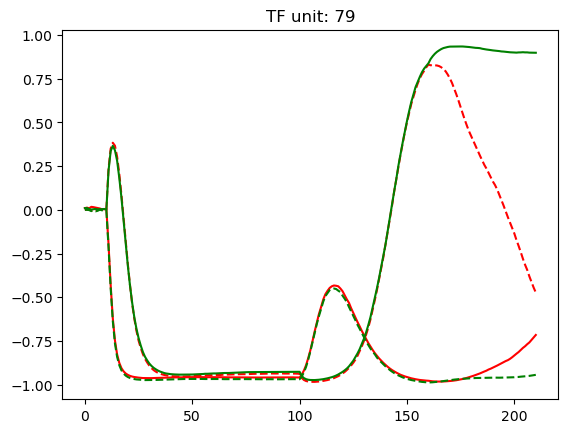

In [10]:
for n in range(70,80):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# train low-rank RNN

In [3]:
# load a full-rank RNN

net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/TFD{size}.pt', map_location='cpu'))

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TFD.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.033, acc=1.000


In [4]:
# define some parameters
# hidden_size: # units in low-rank RNN (should match that in full-rank RNN)
hidden_size = 100
rank = 3

In [5]:
# you have to save model for full-rank RNN, then use that to train low-rank RNN 



# reduce the rank of connectivity matrix 
wi_init = net.wi_full.detach()
wo_init = net.wo_full.detach() * hidden_size
print(wo_init.std())
wrec = net.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(9.4291)
tensor(2.3949)
tensor(0.9865)
torch.Size([100, 3])
torch.Size([100, 3])


In [6]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TFD.generate_checker_data(5000)


In [7]:


# We see that the rank-1 network 
net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)
# net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, rank=2)
train(net_lo, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=50, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.05)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)

loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the low-rank model


Training...
initial loss: 2.079
epoch 0:  loss=0.980  (took 13.30 s) *
epoch 1:  loss=0.460  (took 12.16 s) *
epoch 2:  loss=0.346  (took 11.47 s) *
epoch 3:  loss=0.271  (took 12.05 s) *
epoch 4:  loss=0.225  (took 12.42 s) *
epoch 5:  loss=0.145  (took 12.68 s) *
epoch 6:  loss=0.095  (took 12.11 s) *
epoch 7:  loss=0.079  (took 11.95 s) *
epoch 8:  loss=0.066  (took 11.97 s) *
epoch 9:  loss=0.055  (took 11.44 s) *
epoch 10:  loss=0.051  (took 11.31 s) *
epoch 11:  loss=0.047  (took 11.37 s) *
loss=0.048, acc=1.000


In [38]:
# torch.save(net_lo.state_dict(), "../models/TFD_rank3_1_{}.pt".format(hidden_size))


# Plot psth

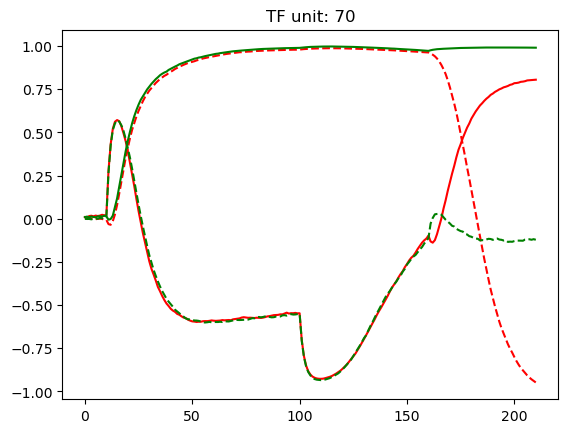

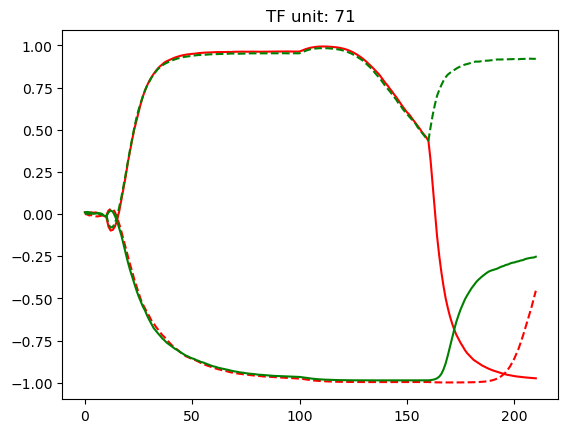

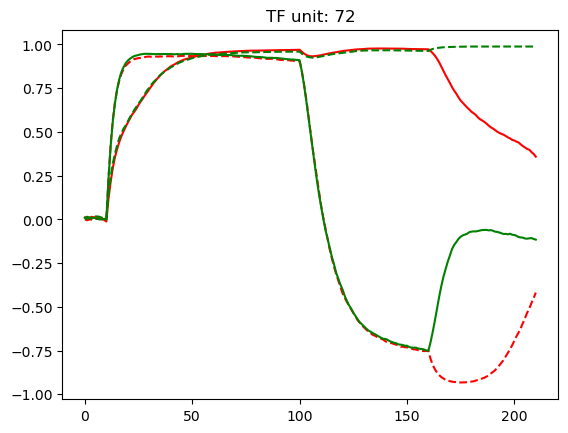

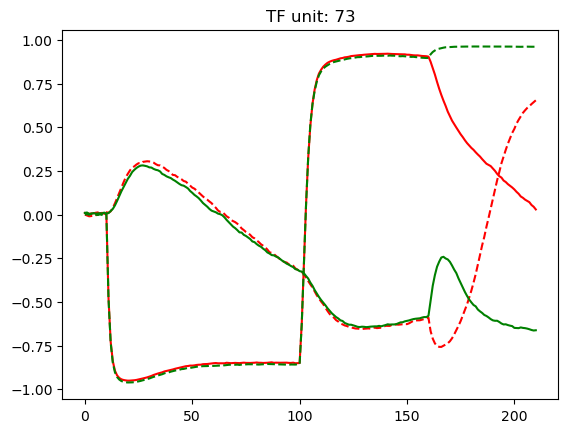

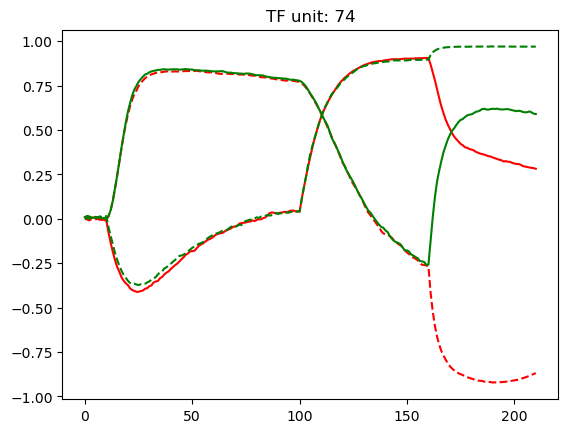

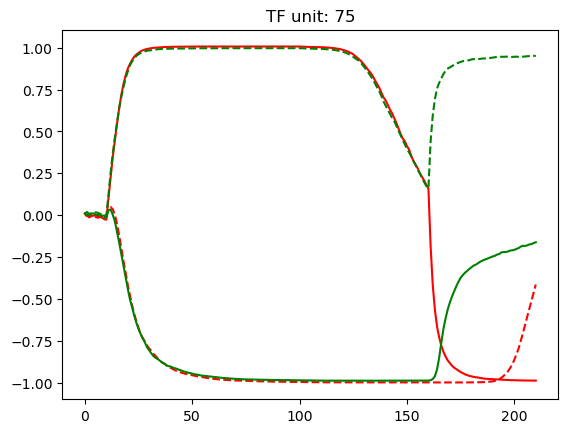

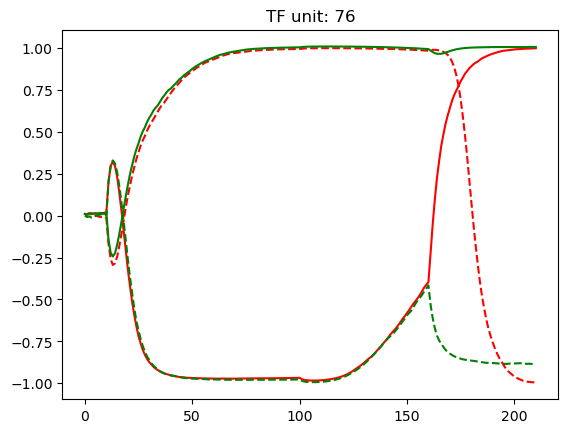

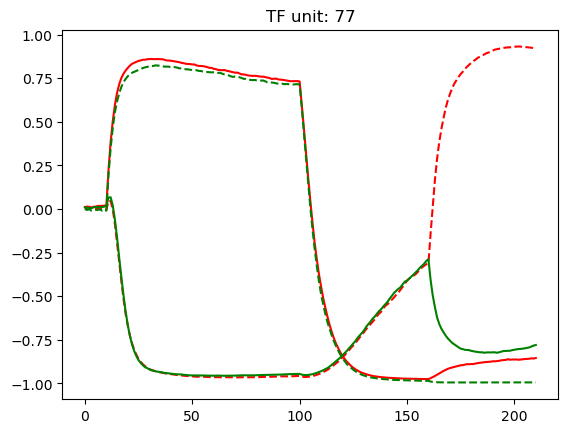

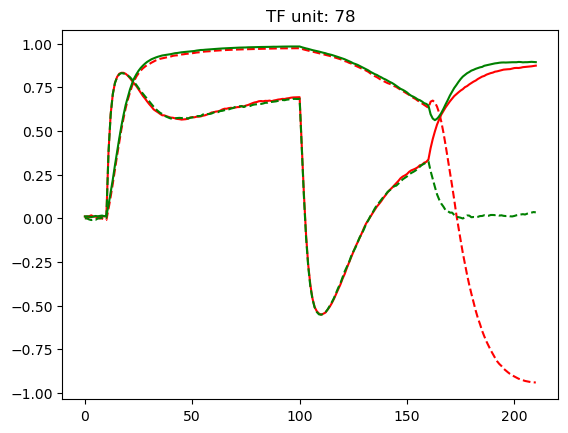

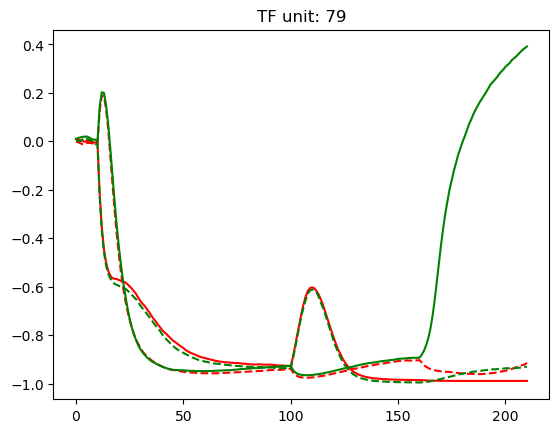

In [8]:
traj1 = traj.detach().numpy()

traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(70,80):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

# full-tank vs low-rank

In [12]:
# # load model
# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# net = FullRankRNN(3, size, 1, noise_std, alpha)
# net.load_state_dict(torch.load(f'../models/TF{size}.pt', map_location='cpu'))

# net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank)
# net_lo.load_state_dict(torch.load(f'../models/TF_rank3_{size}.pt', map_location='cpu'))
# # net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=net_tmp.wi_full, m_init=net_tmp.m, n_init=net_tmp.n, 
# #                   wo_init=net.wo_full * size)
# loss, acc, _, _, _, _ = TF.test_checker(net, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')

# loss, acc, _, _, _, _ = TF.test_checker(net_lo, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')


loss=0.100, acc=0.997
loss=0.111, acc=0.996


<IPython.core.display.Javascript object>


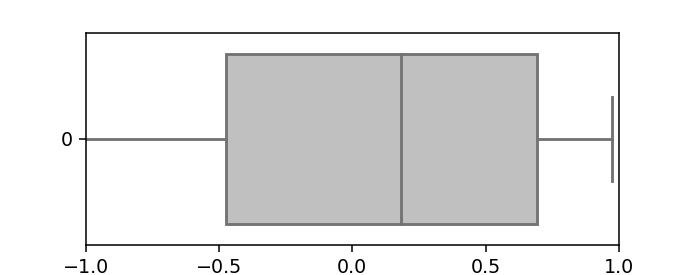

0.45477007106673983
0.18399012282112187


(-1.0, 1.0)

In [13]:
# # ## remember to change the net.nonlinearity

# fig, ax = plt.subplots(figsize=(5, 2))
# outp, traj = net.forward(x_val, return_dynamics=True)
# outp2, traj2 = net_lo.forward(x_val, return_dynamics=True)

# traj = traj.detach().numpy()
# traj2 = traj2.detach().numpy()
# r2_global = stats.r2_score(np.tanh(traj).ravel(), np.tanh(traj2).ravel())

# print(r2_global)
# r2s = stats.r2_idneurons(traj, traj2, return_all=True)
# print(np.median(r2s))
# sns.boxplot(r2s, orient='horizontal', color='silver', ax=ax)
# plt.xlim(-1, 1)

In [9]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()
# n4 = net_lo.n[:, 3].detach().numpy()

# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()
# m4 = net_lo.m[:, 3].detach().numpy()

wo = net_lo.wo.detach().squeeze().numpy()

In [10]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.050, acc=1.000


In [11]:
# generate 4 trials, each represent a condition
# x = TF.generate_ordered_inputs()

# _, trajFull = net.forward(x, return_dynamics=True)
# _, trajLow = net_lo.forward(x, return_dynamics=True)

# trajFull = trajFull.detach().numpy()
# trajLow = trajLow.detach().numpy()

NameError: name 'TF' is not defined

In [20]:
# for ii in range(10,20):
#     plt.figure()
#     plt.plot(trajLow[0,:,ii], 'r-')
#     plt.plot(trajLow[1,:,ii], 'r--')
#     plt.plot(trajLow[2,:,ii], 'g-')
#     plt.plot(trajLow[3,:,ii], 'g--')
#     plt.show()

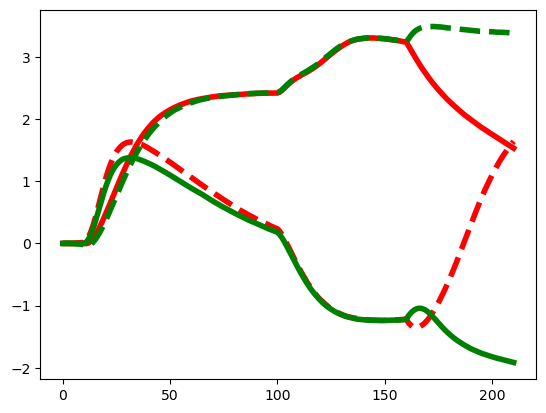

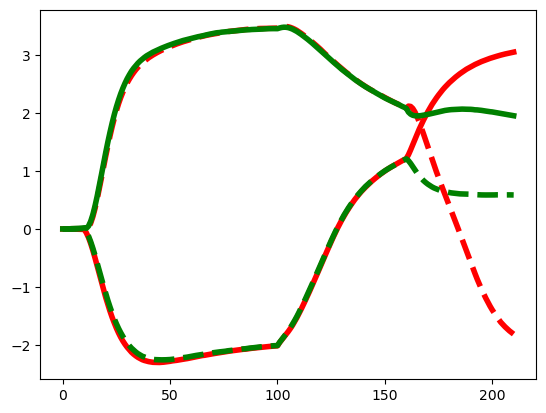

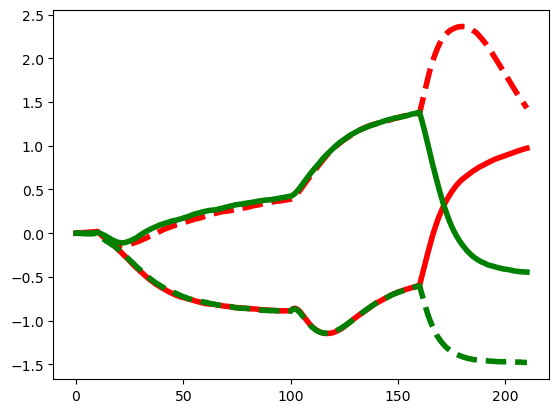

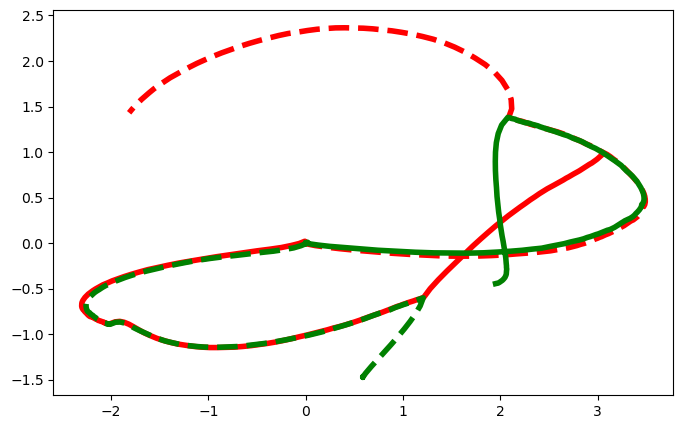

In [12]:
# project full rank rnn traj on m1 vector
# kap1 = trajFull @ m1 / size
# kap2 = trajFull @ m2 / size

# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
# kap4 = trajLow @ m4 / size

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
plt.figure()
for i in range(4):
    plt.plot(kap1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap3[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

# plt.figure()
# for i in range(4):
#     plt.plot(kap4[i], c=colors[i], lw=4, ls=lineStyle[i])
# plt.show()

plt.subplots(figsize=(8,5))
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
for i in range(4):
     plt.plot(kap2[i], kap3[i], c=colors[i], lw=4, ls=lineStyle[i])


In [18]:
# full rank RNN pca
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
TOn = 10
COn = 80

pca = plot.pca_cumvar(trajFull, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()



ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajFull @ ax1
k2 = trajFull @ ax2
k3 = trajFull @ ax3
k4 = trajFull @ ax4

plt.figure()
for i in range(4):
    plt.plot(k2[i], k1[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()
    
# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

NameError: name 'trajFull' is not defined

(844, 100)


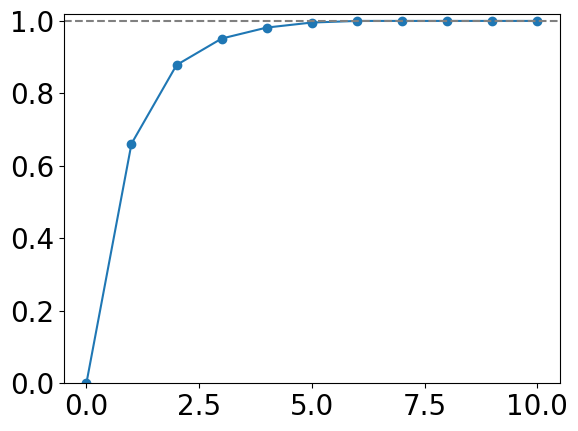

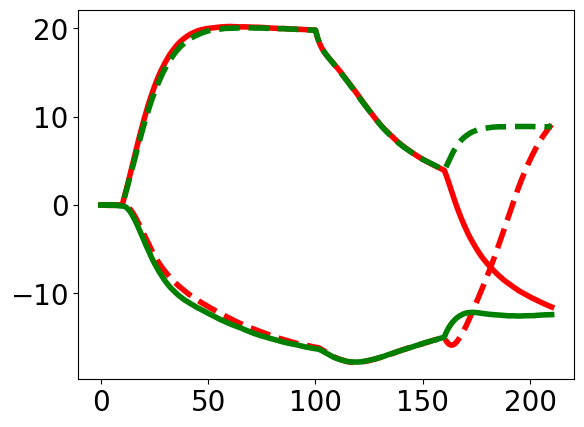

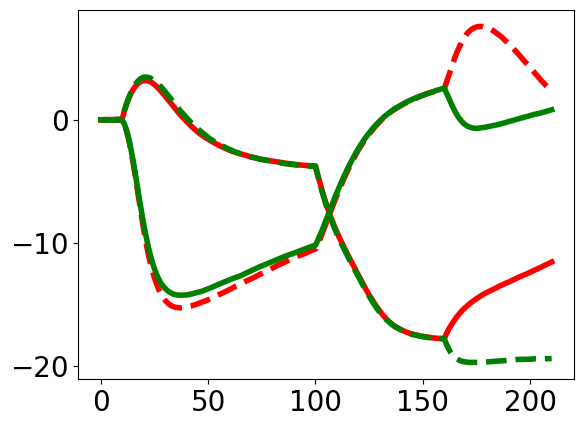

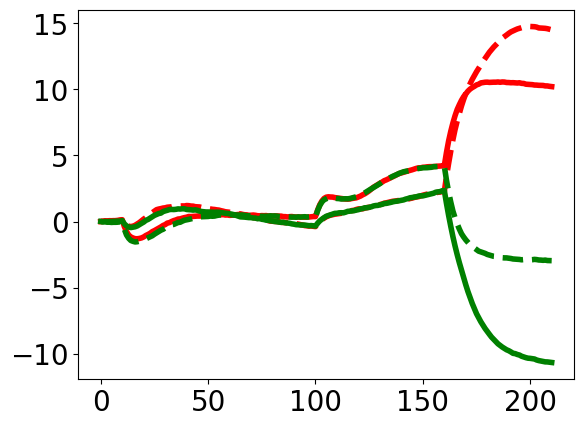

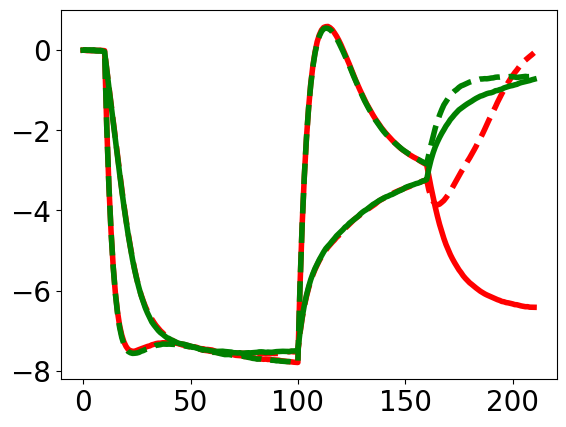

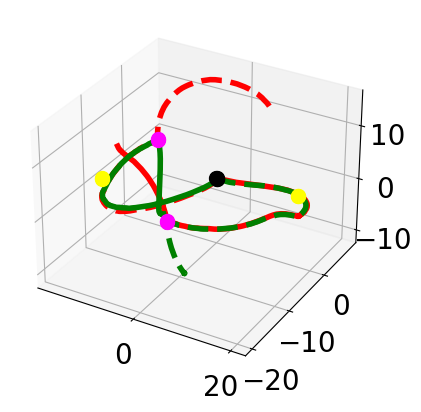

In [20]:
# low rank RNN pca
TOn = 10
COn = 160
TOff = 100

pca = plot.pca_cumvar(trajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajLow @ ax1
k2 = trajLow @ ax2
k3 = trajLow @ ax3
k4 = trajLow @ ax4

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
            marker='.', s=400)
    ax.scatter(k1[i, TOff], k2[i, TOff], k3[i, COn], c= 'yellow',
            marker='.', s=400)
# ax.view_init(elev=38, azim=90)
plt.show()

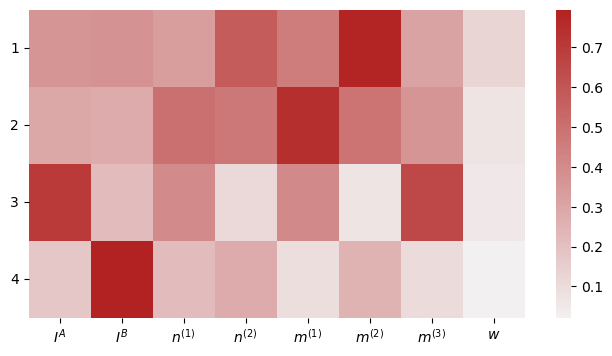

In [14]:
vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, m3, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 8, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$m^{(3)}$','$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

# fields

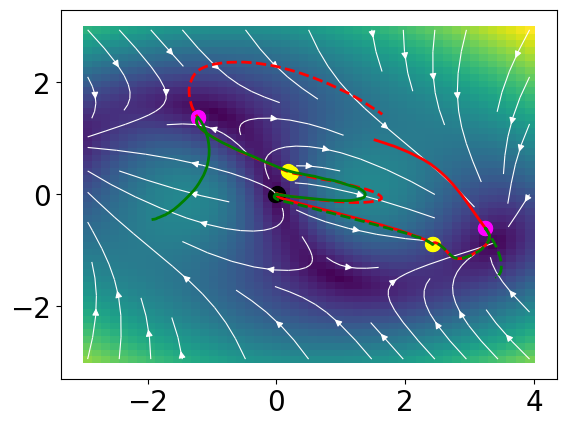

In [22]:

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m2, m3, -3, 4, -3, 3)
for i in range(4):
     plt.plot(kap1[i], kap3[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap1[i, TOn], kap3[i, TOn], c= 'black',
            marker='.', s=400)  
     plt.scatter(kap1[i, COn], kap3[i, COn], c= 'magenta',
            marker='.', s=400)  
     plt.scatter(kap1[i, TOff], kap3[i, TOff], c= 'yellow',
        marker='.', s=400)
plt.show()

(<AxesSubplot:>, <matplotlib.collections.PolyCollection at 0x15137da0208>)

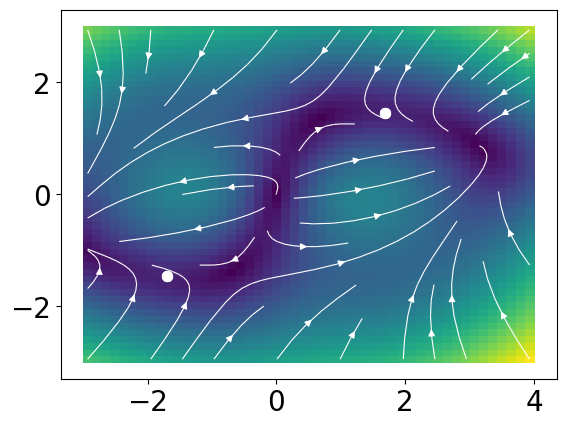

In [39]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m2, m3, -3, 4, -3, 3, add_fixed_points=True, fixed_points_trials=10)
